In [1]:
!pip install keras
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 20.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import warnings
import string
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
import gensim.models
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf
from tensorflow.keras import initializers, preprocessing
import tensorflow_hub as hub
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize


import os
data=[]
for file_name in os.listdir("/kaggle/input/diabetes-subreddits-data-weekly-update/"):
    if file_name.endswith('reddit_with_comments.csv'):
        file_path = os.path.join("/kaggle/input/diabetes-subreddits-data-weekly-update", file_name)
        df = pd.read_csv(file_path)
        data.append(df)
        
combined_df = pd.concat(data, ignore_index=True)
output_file = '/kaggle/working/combined_data.csv'
combined_df.to_csv(output_file, index=False)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [4]:
df_reddit = pd.read_csv('/kaggle/working/combined_data.csv')

In [5]:
df_reddit.shape

(16849, 4)

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
nltk.download('stopwords')
from nltk.corpus import stopwords

print(df_reddit.head())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
                                               Title  \
0  Buying, Selling, Giving Away or Trading Tradin...   
1  Buying, Selling, Giving Away or Trading Tradin...   
2  Buying, Selling, Giving Away or Trading Tradin...   
3  Buying, Selling, Giving Away or Trading Tradin...   
4  Buying, Selling, Giving Away or Trading Tradin...   

                                           Post Text  \
0  Hi there everyone!\n\nI have recently had seve...   
1  Hi there everyone!\n\nI have recently had seve...   
2  Hi there everyone!\n\nI have recently had seve...   
3  Hi there everyone!\n\nI have recently had seve...   
4  Hi there everyone!\n\nI have recently had seve...   

                                            Post URL  \
0  https://www.reddit.com/r/TandemDiabetes/commen...   
1  https://www.reddit.com/r/TandemDiabetes/commen...   
2  https://www.reddit.com/r/Tandem

In [7]:
df["Post Text"] = df["Post Text"].fillna("No Topic Given")
nan_counts = df.isna().sum()

print(nan_counts)

Title        0
Post Text    0
Post URL     0
Comments     0
dtype: int64


In [8]:
# Defining regex patterns.
linebreaks        = "<br /><br />"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

stop_words = set(stopwords.words('english'))
Lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess_reviews(review):

    review = review.lower()

    review = re.sub(linebreaks," ",review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)

    # Replace all emojis.
    review = re.sub(r'<3', '<heart>', review)
    review = re.sub(smileemoji, '<smile>', review)
    review = re.sub(sademoji, '<sadface>', review)
    review = re.sub(neutralemoji, '<neutralface>', review)
    review = re.sub(lolemoji, '<lolface>', review)

    # Remove non-alphanumeric and symbols
    review = re.sub(alphaPattern, ' ', review)
    
    # Tokenize the input text
    tokens = word_tokenize(review)
     
    # Remove stop words from the token sequence

    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the remaining tokens
    tokens = [Lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the cleaned tokens into a single string
    return ' '.join(tokens)
    

In [10]:
df["Text"] = df["Title"] + " " + df["Post Text"]+  " " +  df["Comments"]

In [11]:
df["Text"] = df["Text"].apply(preprocess_reviews)

In [12]:
!curl https://raw.githubusercontent.com/towardsNLP/IMDB-Semantic-Sentiment-Analysis/main/Word2Vec/src/w2v_utils.py -o w2v_utils.py

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25779  100 25779    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k


In [13]:
from w2v_utils import (Tokenizer,
                       evaluate_model,
                       bow_vectorizer,
                       train_logistic_regressor,
                       w2v_trainer,
                       calculate_overall_similarity_score,
                       overall_semantic_sentiment_analysis,
                       list_similarity,
                       calculate_topn_similarity_score,
                       topn_semantic_sentiment_analysis,
                       define_complexity_subjectivity_reviews,
                       explore_high_complexity_reviews,
                       explore_low_subjectivity_reviews,
                       text_SSA)

In [14]:
# Instancing the Tokenizer class
tokenizer = Tokenizer(clean= True,
                      lower= True, 
                      de_noise= True, 
                      remove_stop_words= True,
                      keep_negation=True)

In [15]:
df['tokenized_text'] = df['Text'].apply(tokenizer.tokenize)

df['tokenized_text_len'] = df['tokenized_text'].apply(len)
df['tokenized_text_len'].apply(np.log).describe()

count    3187.000000
mean        4.197037
std         0.909769
min         1.098612
25%         3.663562
50%         4.276666
75%         4.779123
max         6.541030
Name: tokenized_text_len, dtype: float64

In [16]:
keyed_vectors , keyed_vocab = w2v_trainer(df["tokenized_text"])

In [17]:
print(type(keyed_vectors))
print(type(keyed_vocab))

<class 'gensim.models.keyedvectors.KeyedVectors'>
<class 'dict'>


In [18]:
keyed_vectors.most_similar("research",topn=15)

[('google', 0.7864421606063843),
 ('uncontrollable', 0.7333788275718689),
 ('asking', 0.7124702334403992),
 ('claim', 0.7068139910697937),
 ('stemm', 0.7021080851554871),
 ('purpose', 0.666127622127533),
 ('funding', 0.6576111912727356),
 ('speaking', 0.6574840545654297),
 ('family', 0.6488628387451172),
 ('subject', 0.6323352456092834),
 ('proximity', 0.6253991723060608),
 ('suck', 0.6117660403251648),
 ('information', 0.6077041625976562),
 ('hope', 0.6039620637893677),
 ('scrub', 0.5969516634941101)]

In [19]:
keyed_vectors.most_similar("hospital",topn=15)

[('icu', 0.6938815116882324),
 ('whilst', 0.6267244815826416),
 ('multiple', 0.6220124363899231),
 ('spine', 0.6026042103767395),
 ('tamagotchi', 0.5861722230911255),
 ('carrying', 0.5836073756217957),
 ('sent', 0.5835415720939636),
 ('rant', 0.5628315210342407),
 ('496', 0.5174684524536133),
 ('monday', 0.5161126255989075),
 ('christmas', 0.5155751705169678),
 ('related', 0.5123189687728882),
 ('mom', 0.5080675482749939),
 ('3x', 0.49984925985336304),
 ('class', 0.4948106110095978)]

In [20]:
keyed_vectors.most_similar("funded",topn=15)

[('jan', 0.7470957040786743),
 ('funding', 0.7278304100036621),
 ('clinical', 0.70594322681427),
 ('unlucky', 0.7024044394493103),
 ('june', 0.695326566696167),
 ('g7s', 0.694664478302002),
 ('covid', 0.6803408265113831),
 ('coincidence', 0.6778854727745056),
 ('inquire', 0.6766508221626282),
 ('hello', 0.668775737285614),
 ('funny', 0.6670200824737549),
 ('financially', 0.6506563425064087),
 ('stemm', 0.6496835947036743),
 ('340b', 0.6467236280441284),
 ('8yo', 0.6451999545097351)]

In [21]:
keyed_vectors.most_similar("diabetes",topn=15)

[('concerned', 0.5812791585922241),
 ('study', 0.5465072393417358),
 ('perhaps', 0.4657386839389801),
 ('proper', 0.46492207050323486),
 ('donor', 0.457356721162796),
 ('hoping', 0.45243510603904724),
 ('older', 0.449605792760849),
 ('cure', 0.44639766216278076),
 ('mum', 0.44425785541534424),
 ('1st', 0.44222286343574524),
 ('advocate', 0.4417969882488251),
 ('learn', 0.43982094526290894),
 ('doctor', 0.43414032459259033),
 ('whoever', 0.434116005897522),
 ('fianc', 0.43303272128105164)]

In [22]:
# To make sure that all `positive_concepts` are in the keyed word2vec vocabulary
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]

In [23]:
# To make sure that all `negative_concepts` are in the keyed word2vec vocabulary 
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]

In [24]:
# Calculating Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'])

# Calculating Semantic Sentiment Scores by TopSSA model
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'],
                                                     topn=30)


# To store semantic sentiment store computed by OSSA model in df
df['overall_PSS'] = overall_df_scores[0] 
df['overall_NSS'] = overall_df_scores[1] 
df['overall_semantic_sentiment_score'] = overall_df_scores[2] 
df['overall_semantic_sentiment_polarity'] = overall_df_scores[3]

# To store semantic sentiment store computed by TopSSA model in df
df['topn_PSS'] = topn_df_scores[0] 
df['topn_NSS'] = topn_df_scores[1] 
df['topn_semantic_sentiment_score'] = topn_df_scores[2] 
df['topn_semantic_sentiment_polarity'] = topn_df_scores[3]

In [25]:
words = keyed_vectors.index_to_key
vectors = [keyed_vectors[word] for word in words]

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Create a DataFrame with PCA results and words
pca_df = pd.DataFrame(result, columns=['x', 'y'])
pca_df['word'] = words

In [27]:
import plotly.graph_objs as go

fig = go.Figure(data=go.Scattergl(
    x=pca_df['x'],
    y=pca_df['y'],
    mode='markers',
    marker=dict(
        colorscale='Viridis',
        line_width=1
    ),
    text=pca_df['word'],
    textposition="bottom center"
))

fig.show()

Text(0, 0.5, 'Predicted Positive Labels')

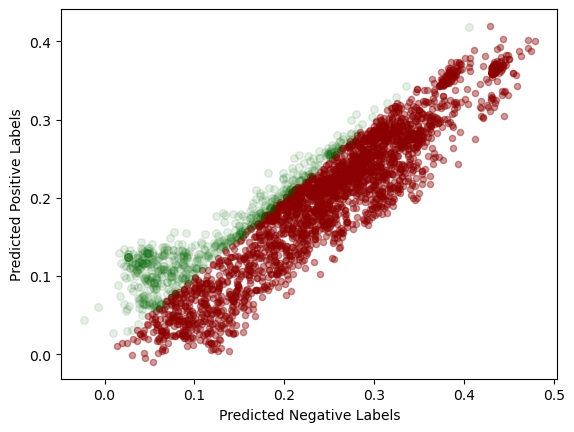

In [28]:
actual_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
actual_neg_filt =  df['topn_semantic_sentiment_polarity'] == 0

# filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
predicted_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
predicted_neg_filt = df['topn_semantic_sentiment_polarity'] == 0



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df['topn_NSS'][actual_neg_filt], 
         df['topn_PSS'][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df['topn_NSS'][actual_pos_filt], 
         df['topn_PSS'][actual_pos_filt],  
         label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Labels')
plt.ylabel('Predicted Positive Labels')

In [29]:
df.head()

,Title,Post Text,Post URL,Comments,Text,tokenized_text,tokenized_text_len,overall_PSS,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity
0,Coronavirus and T1D,"Edit 12/25 As of yesterday, I’m on my 3rd COVI...",https://www.reddit.com/r/Type1Diabetes/comment...,I pinned this to the top of the page so that w...,coronavirus t1d edit 12 25 yesterday 3rd covid...,"[coronavirus, t1d, edit, 12, 25, yesterday, 3r...",336,0.407505,0.470097,-0.062592,0,0.364112,0.432442,-0.068331,0
1,Coronavirus and T1D,"Edit 12/25 As of yesterday, I’m on my 3rd COVI...",https://www.reddit.com/r/Type1Diabetes/comment...,Please just keep us updated as you go! How has...,coronavirus t1d edit 12 25 yesterday 3rd covid...,"[coronavirus, t1d, edit, 12, 25, yesterday, 3r...",338,0.402825,0.465678,-0.062853,0,0.363175,0.432659,-0.069484,0
2,Coronavirus and T1D,"Edit 12/25 As of yesterday, I’m on my 3rd COVI...",https://www.reddit.com/r/Type1Diabetes/comment...,This is really helpful. Thanks for posting.,coronavirus t1d edit 12 25 yesterday 3rd covid...,"[coronavirus, t1d, edit, 12, 25, yesterday, 3r...",331,0.403501,0.471629,-0.068128,0,0.361447,0.431503,-0.070056,0
3,Coronavirus and T1D,"Edit 12/25 As of yesterday, I’m on my 3rd COVI...",https://www.reddit.com/r/Type1Diabetes/comment...,Very glad to hear you and your parents are doi...,coronavirus t1d edit 12 25 yesterday 3rd covid...,"[coronavirus, t1d, edit, 12, 25, yesterday, 3r...",351,0.416083,0.472843,-0.056760,0,0.370948,0.434977,-0.064029,0
4,Coronavirus and T1D,"Edit 12/25 As of yesterday, I’m on my 3rd COVI...",https://www.reddit.com/r/Type1Diabetes/comment...,Please keep us updated. I work in an ICU and p...,coronavirus t1d edit 12 25 yesterday 3rd covid...,"[coronavirus, t1d, edit, 12, 25, yesterday, 3r...",347,0.410471,0.469417,-0.058946,0,0.366218,0.440610,-0.074392,0


In [30]:
df.to_csv('sentiment.csv', index=False)